In [4]:
# libraries to import
from linear_bandits_algorithms import *

# Stochastic Linear Bandits

# Strategy 1: UCB Algorithm

The difference here is that instead of having confidence intervals, we have confidence ellipsoids.

The goal of the algorithm is to optimize the selection of actions (arms) in order to maximize the cumulative reward received over a series of rounds.

The key idea behind the algorithm is to model the relationship between the observed rewards and the features of each arm using linear regression, and then use the estimated regression coefficients to make informed decisions about which arm to select in each round.

### Steps of the algorithm



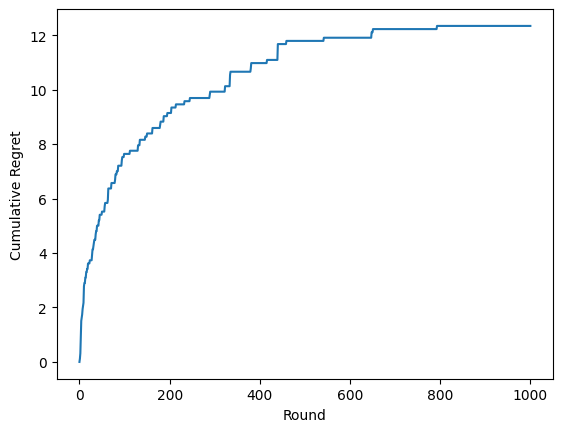

In [40]:
# Setting up parameters for the runs
n_arms = 10
n_features = 5
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

def RunLinUCB(n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param):

    # Initializing the LinUCB class
    linucb = LinUCB(n_arms, n_features, item_features, n_rounds, lambda_param)

    # Initializing the environment
    environment = EnvironmentLinUCB(n_arms, n_features, item_features, n_rounds, true_theta, noise)

    for t in range(1, n_rounds + 1):

        # Picking up the best action based on theta_hat
        arm_chosen = linucb.choose_action(t)

        # Reward received based on the action taken
        expected_reward, reward_with_noise = environment.observe_reward(t, arm_chosen)

        # Compute regret
        environment.calculate_regret(t, expected_reward)

        # Update algorithm values after receiving reward
        linucb.update(t, reward_with_noise)

    regrets = environment.get_regrets()

    # Plot the results
    plt.plot(regrets)
    plt.xlabel('Round')
    plt.ylabel('Cumulative Regret')
    plt.show()

    # Printing the true theta a
    # print("The true theta is equal to : " + str(true_theta))
    # print("The theta hat we find at the end is equal to : ", str(theta_hat))

RunLinUCB(n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)